<h1 style = 'color:red'>Prerequisites</hr>

In [2]:
import csv
import pandas as pd
import os
import shutil
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

def add_data(filename:str):

    df = pd.read_csv(filename)
    df["HomeWinRate"] = float("nan")
    df["AwayWinRate"] = float("nan")
    df["isWin"] = float("nan")

    all_teams_list = []
    file = open(filename)
    csvreader = csv.DictReader(file)
    for row in csvreader:
        all_teams_list.append(row['HomeTeam'])
        all_teams_list.append(row['AwayTeam'])

    all_teams_list = list(set(all_teams_list))
    all_teams_list.sort()

    labels = [
        ("FTHG", "FTAG"),
        ("HTHG", "HTAG"),
        ("HS", "AS"),
        ("HST", "AST"),
        ("HF", "AF"),
        ("HC", "AC"),
        ("HY", "AY"),
        ("HR", "AR"),
    ]

    for team in all_teams_list:
        a = df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)]
        count = 0
        perf = {
            "Wins": 0,
            "FTHG": 0,
            "HTHG": 0,
            "HS": 0,
            "HST": 0,
            "HF": 0,
            "HC": 0,
            "HY": 0,
            "HR": 0,
        }
        # print("team: " + str(team))
        for i, row in a.iterrows():
            if row['HomeTeam'] == team:
                for l in labels:
                    df.loc[i,l[0]] = (float("nan") if count == 0 else perf[l[0]] / count)
                    perf[l[0]] += row[l[0]]
                df.loc[i,"HomeWinRate"] = (float("nan") if count == 0 else perf["Wins"] / count)
                if row["FTR"] == "H":
                    perf["Wins"] += 1
                    df.loc[i,"isWin"] = 1
                else:
                    df.loc[i,"isWin"] = 0
            elif row["AwayTeam"] == team:
                for l in labels:
                    df.loc[i,l[1]] =  (float("nan") if count == 0 else perf[l[0]] / count)
                    perf[l[0]] += row[l[1]]
                df.loc[i,"AwayWinRate"] = (float("nan") if count == 0 else perf["Wins"] / count)
                if row["FTR"] == "A":
                    perf["Wins"] += 1
            else:
                raise Exception("away team or home team not found")
            count += 1
    #remove rows where average is NAN (we dont have historical data yet)
    df = df[df['FTHG'].notna() & df['FTAG'].notna()]



    return remove_cols(df)
    

def remove_cols(df):
    labels = [
        ("FTHG", "FTAG"),
        ("HTHG", "HTAG"),
        ("HS", "AS"),
        ("HST", "AST"),
        ("HF", "AF"),
        ("HC", "AC"),
        ("HY", "AY"),
        ("HR", "AR"),
    ]
    columns = ["Date", "HomeTeam", "AwayTeam", "AwayWinRate", "HomeWinRate", "FTR", "isWin"]
    h = [x[0] for x in labels]
    a = [x[1] for x in labels]
    kept_csv = h + a + columns
    df.drop(df.columns.difference(kept_csv), 1, inplace=True)
    return df

def automated_preprocessing(addr):
    data_dir = addr
    #list of training and test set
    training_set = ['1213','1314', '1415', '1516', '1617', '1718']
    test_set = ['1819']

    #Taking care of the first season to initialize the base DF
    merged_orig = add_data(data_dir + training_set[0] +'\\merged.csv')
    merged_orig = merged_orig.loc[:, merged_orig.columns!='Unnamed: 0']


    for filename in training_set[1:]:
        pd1 =  add_data(data_dir+filename+'\\'+'merged.csv')
        pd1 = pd1.loc[:, pd1.columns!='Unnamed: 0']
        merged_orig = merged_orig.append(pd1)
        print('season ' +filename+' has been preprocessed and added to the base DF______')
        
    training_addr = data_dir+'Training_Testing\\training'+training_set[0]+'_TO_'+training_set[len(training_set) - 1]+'.csv'
    merged_orig.to_csv(training_addr)
    
    testing_addr = data_dir+'Training_Testing\\testing_'+test_set[0]+'.csv'
    testing_src = data_dir + test_set[0] +'\\'+'merged.csv'
    pd1 =  add_data(testing_src)
    pd1 = pd1.loc[:, pd1.columns!='Unnamed: 0']
    pd1.to_csv(testing_addr)
    print('testing ' +test_set[0]+' has been preprocessed and seperated______')
    
    
    print('__________Removing NA__________')
    testing_dest = data_dir +'\\'+'Training_Testing'+'\\testing_'+test_set[0]+'.csv'
    training_ready_set, testing_ready_set = remove_NA([training_addr, testing_addr])
    training_ready_set.to_csv(training_addr)
    testing_ready_set.to_csv(testing_dest)
    
    return (training_ready_set, testing_ready_set)
    
def remove_NA(data_path):
    holder = list()
    for path in data_path:
        data =  pd.read_csv(path)
        data.columns[0:4].tolist()
        data = data.drop(['Unnamed: 0', 'Date', 'HomeTeam', 'AwayTeam', 'FTR'],1).reset_index()
        for i in data.columns.tolist():
            data[i].replace('', np.nan, inplace=True)
            data.dropna(subset=[i], inplace=True)
        holder.append(data)
        print(path + " is cleaned")
    return holder[0], holder[1]

<h2 style = 'color: orange'>--PCA </h1>

In [3]:
data_dir = 'Final Project\\'
training_set, testing_set= automated_preprocessing(data_dir)


C:\Users\ccxbo\AppData\Local\Temp\ipykernel_3900\115950156.py:99: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(kept_csv), 1, inplace=True)
C:\Users\ccxbo\AppData\Local\Temp\ipykernel_3900\115950156.py:99: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(kept_csv), 1, inplace=True)
C:\Users\ccxbo\AppData\Local\Temp\ipykernel_3900\115950156.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_orig = merged_orig.append(pd1)


season 1314 has been preprocessed and added to the base DF______


C:\Users\ccxbo\AppData\Local\Temp\ipykernel_3900\115950156.py:99: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(kept_csv), 1, inplace=True)
C:\Users\ccxbo\AppData\Local\Temp\ipykernel_3900\115950156.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_orig = merged_orig.append(pd1)


season 1415 has been preprocessed and added to the base DF______


C:\Users\ccxbo\AppData\Local\Temp\ipykernel_3900\115950156.py:99: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(kept_csv), 1, inplace=True)
C:\Users\ccxbo\AppData\Local\Temp\ipykernel_3900\115950156.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_orig = merged_orig.append(pd1)


season 1516 has been preprocessed and added to the base DF______


C:\Users\ccxbo\AppData\Local\Temp\ipykernel_3900\115950156.py:99: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(kept_csv), 1, inplace=True)
C:\Users\ccxbo\AppData\Local\Temp\ipykernel_3900\115950156.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_orig = merged_orig.append(pd1)


season 1617 has been preprocessed and added to the base DF______


C:\Users\ccxbo\AppData\Local\Temp\ipykernel_3900\115950156.py:99: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(kept_csv), 1, inplace=True)
C:\Users\ccxbo\AppData\Local\Temp\ipykernel_3900\115950156.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_orig = merged_orig.append(pd1)


season 1718 has been preprocessed and added to the base DF______


C:\Users\ccxbo\AppData\Local\Temp\ipykernel_3900\115950156.py:99: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(kept_csv), 1, inplace=True)


testing 1819 has been preprocessed and seperated______
__________Removing NA__________


C:\Users\ccxbo\AppData\Local\Temp\ipykernel_3900\115950156.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop(['Unnamed: 0', 'Date', 'HomeTeam', 'AwayTeam', 'FTR'],1).reset_index()


Final Project\Training_Testing\training1213_TO_1718.csv is cleaned
Final Project\Training_Testing\testing_1819.csv is cleaned


C:\Users\ccxbo\AppData\Local\Temp\ipykernel_3900\115950156.py:143: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop(['Unnamed: 0', 'Date', 'HomeTeam', 'AwayTeam', 'FTR'],1).reset_index()


<h2 style = 'color: orange'>--KMean </h1>

In [4]:
print(testing_set)


      index      FTHG      FTAG      HTHG      HTAG         HS         AS  \
0         0  1.000000  4.000000  0.000000  3.000000  13.000000  10.000000   
1         1  2.000000  2.000000  0.000000  0.000000  14.000000  17.000000   
2         2  2.000000  1.000000  1.000000  0.000000  10.000000  15.000000   
3         3  1.000000  0.000000  0.000000  0.000000   8.000000  22.000000   
4         4  0.000000  2.000000  0.000000  1.000000  13.000000  11.000000   
...     ...       ...       ...       ...       ...        ...        ...   
1770   1770  2.351351  1.270270  1.000000  0.459459  15.162162  12.621622   
1771   1771  1.756757  0.864865  0.945946  0.270270  13.513514  10.918919   
1772   1772  1.189189  0.567568  0.567568  0.297297  12.702703  10.540541   
1773   1773  1.756757  1.405405  0.810811  0.675676  14.189189  12.918919   
1774   1774  1.378378  1.297297  0.486486  0.540541  11.270270  11.486486   

           HST       AST         HF         AF        HC        AC        H

In [5]:
#--------------- Elbow to find see the best number of cluster
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show() 


NameError: name 'X' is not defined

In [ ]:
n_cluster = 3
#--------------- Selecting the best n as our n_cluster
kmeans = KMeans(n_cluster, init='k-means++', max_iter=300, n_init=300, random_state=0)
pred_y = kmeans.fit_predict(X)

#--------------- Viz our clusters
plt.scatter(X[:,0], X[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()


NameError: name 'X' is not defined

In [ ]:
labels2 = kmeans.labels_
centroids2=kmeans.cluster_centers_
UD = training_set[[i for i in training_set.columns if i not in ["isWin", "label"]]]
legend = [list(UD.columns), list(UD.columns)]
t_l = list()
for i in legend[0]:
    for j in legend[1]:
        t_l.append((i, j))
        
h = 0.003
x_min, x_max = X[:, 0].min() - 1, X[: , 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[: , 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
z2 = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1, figsize = (15, 7))
plt.clf()
z2 = z2.reshape(xx.shape)
plt.imshow(z2, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')
plt.scatter(X[:,0], X[:,1], c = labels2, s = 100)
plt.scatter(x = centroids2[:, 0], y = centroids2[:, 1], s = 200, c = 'red', alpha = 0.5)
plt.ylabel, plt.xlabel
plt.show()

In [6]:
testing_set_x = testing_set.drop("isWin", axis=1)
training_set_x = training_set.drop("isWin", axis=1)

X_test = testing_set_x.to_numpy()
X = training_set_x.to_numpy()

X_input_test = StandardScaler().fit_transform(X_test)
X_input = StandardScaler().fit_transform(X)

# Logistic Regression

C:\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

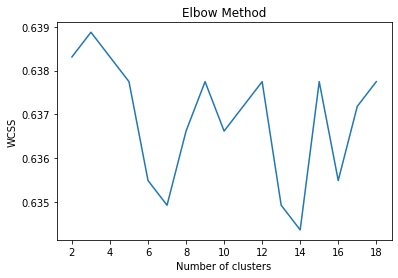

In [ ]:
scores = []

for i in range(2, 19):
    pca = PCA(n_components=i)
    X = pca.fit_transform(X_input)
    X_test = pca.fit_transform(X_input_test)

    train_y = training_set[["isWin"]]
    test_y = testing_set[["isWin"]]

    model = LogisticRegression(solver='liblinear', random_state=0)
    model.fit(X, train_y)
    score = model.score(X_test, test_y)
    
    scores.append(score)
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X, train_y)
score = model.score(X_test, test_y)

plt.plot(range(2, 19), scores)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show() 




# Neural Network

Epoch 1/80
1332/1332 [==============================] - 3s 2ms/step - loss: 0.6429 - accuracy: 0.6317 - val_loss: 0.6357 - val_accuracy: 0.6338
Epoch 2/80
1332/1332 [==============================] - 2s 2ms/step - loss: 0.6294 - accuracy: 0.6439 - val_loss: 0.6315 - val_accuracy: 0.6479
Epoch 3/80
1332/1332 [==============================] - 2s 2ms/step - loss: 0.6272 - accuracy: 0.6453 - val_loss: 0.6301 - val_accuracy: 0.6501
Epoch 4/80
1332/1332 [==============================] - 2s 2ms/step - loss: 0.6248 - accuracy: 0.6481 - val_loss: 0.6324 - val_accuracy: 0.6468
Epoch 5/80
1332/1332 [==============================] - 2s 2ms/step - loss: 0.6217 - accuracy: 0.6518 - val_loss: 0.6373 - val_accuracy: 0.6417
Epoch 6/80
1332/1332 [==============================] - 2s 2ms/step - loss: 0.6210 - accuracy: 0.6539 - val_loss: 0.6301 - val_accuracy: 0.6479
Epoch 7/80
1332/1332 [==============================] - 2s 1ms/step - loss: 0.6186 - accuracy: 0.6568 - val_loss: 0.6324 - val_accuracy:

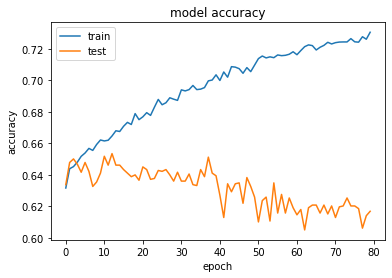

In [30]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
scores = []

# for i in range(2, 19, 2):
# pca = PCA(n_components=i)
# X = pca.fit_transform(X_input)
# X_test = pca.fit_transform(X_input_test)
i = 19
X = X_input
X_test = X_input_test
train_y = training_set[["isWin"]]
test_y = testing_set[["isWin"]]

# model = LogisticRegression(solver='liblinear', random_state=0)
# model.fit(X, train_y)
# score = model.score(X_test, test_y)
model = Sequential()
model.add(Dense(12, input_dim=i, activation='relu'))
model.add(Dense(i, activation='relu'))
model.add(Dense(i, activation='relu'))
model.add(Dense(i, activation='relu'))
model.add(Dense(i, activation='relu'))
model.add(Dense(int(i/2), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile( loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X, train_y,validation_data=(X_test, test_y), epochs=80, batch_size=10)
_, accuracy = model.evaluate(X_test, test_y)
print(accuracy)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# scores.append(accuracy)

dict_keys(['loss', 'accuracy'])


ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

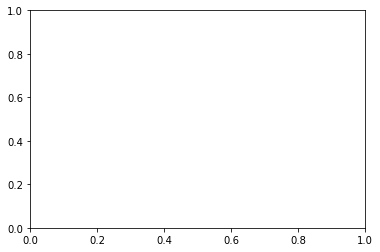

In [27]:
print(history.history.keys())
plt.plot(range(2, 19, 2), scores)
plt.title('PCA components with Neural Network')
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.show() 
